# TME3: How Much Did It Rain? II

https://www.kaggle.com/c/how-much-did-it-rain-ii


Car cancellation guide:
https://github.com/numb3r33/Kaggle-Competitions/blob/master/cars-cancellation/cars_cancellation.ipynb


En pluviométrie, pour mesurer les hauteurs des précipitations on utilise des jauges qui receuillent la pluie. On est alors capable de déterminer la quantité d'eau tombée durant un intervalle de temps donné, ici une heure.
Cependant, les jauges ne peuvent pas couvrir l'ensemble des lieux que l'on souhaite observer. On utilise alors des radars et on estime la hauteur des précipitations à partir de leurs relevés.
Cependant, ces estimations correspondent mal aux mesures effectués sur les jauges.
L'objectif de ce challenge est de fournir un meilleur estimateur basée sur les relevés des radars.

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sb
%matplotlib inline  

from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import mean_absolute_error

# Chargement des données

Les données sont des séquences de relevés de capteurs sur une durée d'une heure à des temps variables.
A chaque séquence est associée un identifiant et la distance du capteur à une jauge dont il faut prédire les mesures à la fin de l'heure.
Un élément de la séquence contient les différentes mesures effectués par le radar à un instant donné.

In [4]:
%%time
dfTrain = pd.read_csv('./data/train.csv')
dfTrain['Id_index'] = dfTrain['Id']
dfTrain = dfTrain.set_index('Id_index')

CPU times: user 36.2 s, sys: 8.8 s, total: 45 s
Wall time: 46.6 s


In [3]:
dfTest = pd.read_csv('./data/test.csv')
dfTest = dfTest.set_index('Id')

# Premier aperçu

On commence par regarder succintement les données. On cherche à répondre à des questions d'ordre général sur les données:
Nombre de séquences et nombre de relevés, nombre de dimension, il y a-t-il des dimensions catégorielles à traiter et y a-t-il des données manquantes?

Un premier résumé permet de dire qu'il y a 13765201 entrées de 24 dimensions (23 si on exclu la quantité a prédire), toutes numériques.
On voit aussi en extrayant la tête et la queue de la table qu'il y a un certain nombre de données manquantes et qu'il y a 1180945 séquences.

In [118]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13765201 entries, 1 to 1180945
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.6 GB


In [119]:
dfTrain.head(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1,1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,55,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,2,1,2,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
2,2,6,2,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
2,2,11,2,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016


In [120]:
dfTrain.tail(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1180945,1180945,14,9,33.5,NaN,32.5,46.5,35.5,6.5,35.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,19,9,43.5,9.5,39.0,49.5,43.5,15.5,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,24,9,31.5,19.5,31.5,41.0,31.5,20.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,28,9,24.0,25.5,31.0,41.0,24.0,25.5,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,33,9,25.5,22.0,27.0,31.0,29.0,25.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,38,9,33.0,19.5,25.5,36.5,33.0,20.5,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,42,9,33.0,21.0,30.5,37.0,36.5,22.0,33.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,47,9,29.5,10.0,26.0,30.5,31.0,16.5,26.0,...,1.051667,1.75,NaN,0.750,3.0000,13.379990,NaN,NaN,13.379990,8.636004
1180945,1180945,52,9,19.0,NaN,15.5,26.5,19.0,NaN,16.5,...,1.051667,NaN,NaN,NaN,2.8125,NaN,NaN,NaN,NaN,8.636004


## Distribution des données

On s'intéresse à la distribution des données, en particulier la quantité de données manquantes et la distribution de la quantité à prédire.

La ligne count nous permet d'évaluer que pour la plupart des colonnes, environ la moitié des données sont manquantes.
La distribution de la colonne Expected est particulière dans le sens où les 3 premiers quartiles sont très bas (respectivement 0.25, 1.02 et 3.81) alors que la moyenne est à 108.63 et le maximum à 33017.73.
C'est-à-dire que la grande majorité des valeurs sont très petites et les grandes valeurs sont extrêmement grandes.
Ceci explique aussi le choix d'une pénalisation sur la norme L1 plutot que L2 qui risquerait de donner un poids démesuré à ces valeurs extrêmes.

In [121]:
dfTrain.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,13765201.000000,13765201.000000,13765201.000000,6349375.000000,5283988.000000,6356482.000000,7551281.000000,6716343.000000,5755673.000000,6711663.000000,...,5905584.000000,4934916.000000,4133154.000000,4936568.000000,5905584.000000,4182635.000000,3428782.000000,4187281.000000,5052776.000000,13765201.000000
mean,592336.986614,29.523733,11.067943,22.926658,19.952271,22.610287,25.898461,24.711081,22.158238,24.420753,...,1.015272,0.536709,-0.719008,0.337622,2.072870,0.035452,-3.482325,-0.473655,4.079836,108.626306
std,340856.086254,17.308131,4.206618,10.355157,9.208166,10.053000,11.109579,10.689622,9.702705,10.424526,...,0.048616,1.510399,1.006068,0.938644,1.670194,3.869725,2.792120,2.263046,4.147337,548.605805
min,1.000000,0.000000,0.000000,-31.000000,-32.000000,-32.000000,-28.500000,-32.000000,-31.000000,-27.500000,...,0.208333,-7.875000,-7.875000,-7.875000,-7.875000,-96.040000,-80.790000,-78.770004,-100.200005,0.010000
25%,296897.000000,15.000000,9.000000,16.000000,14.000000,16.000000,18.000000,17.500000,16.000000,17.500000,...,0.998333,-0.187500,-1.125000,-0.062500,1.062500,-1.410004,-4.580002,-0.710007,2.069992,0.254000
50%,592199.000000,30.000000,11.000000,22.500000,20.000000,22.500000,25.500000,24.000000,22.000000,24.000000,...,1.011667,0.375000,-0.625000,0.250000,1.687500,0.000000,-2.820007,0.000000,3.519989,1.016000
75%,889582.000000,44.000000,14.000000,29.500000,26.000000,29.000000,33.500000,31.500000,28.500000,31.500000,...,1.051667,1.062500,-0.187500,0.687500,2.625000,1.750000,-1.760010,0.349991,5.639999,3.810002
max,1180945.000000,59.000000,21.000000,71.000000,62.500000,69.000000,72.500000,92.500000,66.000000,71.000000,...,1.051667,7.937500,7.937500,7.937500,7.937500,179.750000,3.519989,12.800003,144.600000,33017.730000


Il semble important de souligner le fait que pour chaque séquence de $n$ relevés radars, la production de ces derniers est espacée d'un temps égal. Le premier est produit à 00:00, le dernier à 59:00. De cette manière nous n'avons pas à créer de features trop complexes utilisant cette dimension "minutes_past" et pouvons nous contenter de mesures statistiques comme la moyenne, la std, les quantiles, le min, le max, etc.

### Données manquantes

Il y aurait 38% de données manquantes
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16572/38-missing-data

Combien y'a-t-il de données manquantes par dimension ?

In [19]:
l = float(len(dfTrain["Id"]))
comp = []
for i in dfTrain.columns:
    comp.append([1 - dfTrain[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)
print(comp)
compA = np.array(comp)

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.56876779351060691, 'RefComposite_5x5_90th'],
 [0.54857760522349075, 'Ref_5x5_90th'],
 [0.48792189812557041, 'RefComposite'],
 [0.48758191035495957, 'RefComposite_5x5_50th'],
 [0.46177909062134292, 'Ref_5x5_50th'],
 [0.4612627886799473, 'Ref'],
 [0.42902272186217982, 'RhoHV_5x5_90th'],
 [0.42902272186217982, 'Zdr_5x5_90th'],
 [0.41813214351174388, 'RefComposite_5x5_10th'],
 [0.38386566240478437, 'Ref_5x5_10th'],
 [0.36706881359741861, 'Kdp_5x5_90th'],
 [0.35862665572409735, 'RhoHV_5x5_50th'],
 [0.35862665572409735, 'Zdr_5x5_50th'],
 [0.35850664294695012, 'RhoHV'],
 [0.35850664294695012, 'Zdr'],
 [0.30419323335707193, 'Kdp_5x5_50th'],
 [0.30385571558308522, 'Kdp'],
 [0.30026107137847102, 'RhoHV_5x5_10th'],
 [0.30026107137847102, 'Zdr_5x5_10th'],
 [0.2490905871988357, 'Kdp_5x5_10th']]

Combien y'a-t-il de séquences totalement nulles sauf minutes_past, radardist_km et expected ?
> environ 40% du trainset ne possède que des features nulles

In [85]:
dfLight = dfTrain.drop(['minutes_past','radardist_km', 'Expected'],axis=1)
nbIds = len(dfLight.index)
nbIdsAllNan = len(dfLight.dropna(how='all').index)
nbIdsAnyNan = len(dfLight.dropna(how='any').index)
print "nombre de séquences avec NaN:", nbIds
print "nombre de séquences sans all NaN:", nbIdsAllNan, (nbIdsAllNan * 1. / nbIds * 100)
print "nombre de séquences sans any NaN:", nbIdsAnyNan, (nbIdsAnyNan * 1. / nbIds * 100)

nombre de séquences avec NaN: 13765201
nombre de séquences sans all NaN: 8476966 61.5825805958
nombre de séquences sans any NaN: 2769088 20.1165823877


L'administrateur du challenge précise que les séquences pour lesquelles toutes les Ref (colonne \#4) sont manquantes ne seront pas prises en compte, alors nous allons les enlever.
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16622/ignored-ids

Nous travaillons souvent sur un subset pour tester notre code.

In [59]:
# df = dfTrain[dfTrain.index < 5]

In [5]:
def myfunc(seq):
    nb = len(seq['Ref'])
    if (seq['Ref'].isnull()).sum() == nb:
        return seq['Id'].values[0]
    return -1
    
def identity(seq):
    print(seq)
    return seq
    
dfGrouped = dfTrain.groupby(dfTrain.index)
dfIds2rmv = dfGrouped.apply(myfunc)

In [61]:
#dfIds2rmv

In [6]:
df = dfTrain.drop(dfIds2rmv.values,axis=0)

Combien a-t-on enlevé de lignes ?

In [173]:
print len(dfTrain), '*', len(df)*1./len(dfTrain)*100, '% = ', len(df)

9125329 * 100.0 % =  9125329


Et maintenant ? Combien y'a-t-il de données manquantes par dimension ?

In [66]:
l = float(len(df["Id"]))
comp = []
for i in df.columns:
    comp.append([1 - df[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)
comp

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.83874674545980754, 'RefComposite_5x5_90th'],
 [0.81298690710219867, 'Ref_5x5_90th'],
 [0.73376576340425648, 'RefComposite'],
 [0.73326320618138807, 'RefComposite_5x5_50th'],
 [0.6961873922573093, 'Ref_5x5_50th'],
 [0.69579683099644951, 'Ref'],
 [0.62983877074459449, 'RefComposite_5x5_10th'],
 [0.62100906170067949, 'RhoHV_5x5_90th'],
 [0.62100906170067949, 'Zdr_5x5_90th'],
 [0.5790412597726613, 'Ref_5x5_10th'],
 [0.53625069298871308, 'Kdp_5x5_90th'],
 [0.5287214302081602, 'RhoHV_5x5_50th'],
 [0.5287214302081602, 'Zdr_5x5_50th'],
 [0.52724093564188212, 'RhoHV'],
 [0.52724093564188212, 'Zdr'],
 [0.44919027029052871, 'Kdp_5x5_50th'],
 [0.44806943398972243, 'Kdp'],
 [0.44635716695803518, 'RhoHV_5x5_10th'],
 [0.44635716695803518, 'Zdr_5x5_10th'],
 [0.37034357884521207, 'Kdp_5x5_10th']]

Essayons de trouver des typologies de séquences seulement en les regardants.
> Ci-dessous on peut voir que certaines colonnes sont totalement vides. Nous pensons alors qu'il va nous falloir développer des algorithmes plus ou moins complexes de remplissage des ces valeurs NaN.

In [73]:
df.loc[4]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
4,4,0,9,18.5,16.0,19.0,23.5,24.5,22.0,23.5,...,0.998333,NaN,NaN,NaN,1.4375,NaN,NaN,NaN,NaN,4.064002
4,4,5,9,22.0,14.0,21.0,30.0,25.5,22.5,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,9,9,35.5,24.5,30.5,35.5,35.5,25.5,31.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,14,9,16.5,NaN,19.0,34.5,23.5,16.5,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,19,9,16.0,NaN,11.0,18.0,20.5,13.5,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,23,9,NaN,NaN,NaN,26.0,7.5,12.0,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,28,9,32.5,10.5,34.5,43.0,42.5,19.5,39.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,33,9,41.5,33.5,39.5,44.5,43.0,36.0,41.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,38,9,34.0,33.5,37.5,42.5,37.0,35.5,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002


### Outliers
https://www.kaggle.com/sudalairajkumar/how-much-did-it-rain-ii/rainfall-test/log
Les valeurs de expected au dessus de 1000 mm/h peuvent être des erreurs 

ou alors

https://www.kaggle.com/c/how-much-did-it-rain/forums/t/11479/expected/62593
Some of the extremely high Expected values may be due to the melting of ice precipitation that has collected in the rain gauge, which would release a flood of water in a relatively short period of time. If the rain gauges are heated, then snow filling the gauge and then melting later should not be as much of an issue, but hail or graupel filling the top of the gauge could cause underestimation initially by blocking rain from entering the gauge, then overestimation due to melting and draining into the gauge. The real trick will be to train an algorithm to recognize these instances.

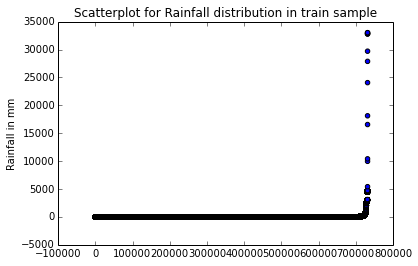

In [9]:
dfTrainGb = df.groupby(df.index)
exp_rainfall = np.sort(np.array(dfTrainGb['Expected'].aggregate('mean')))
plt.figure()
plt.scatter(np.arange(exp_rainfall.shape[0]), exp_rainfall)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Rainfall in mm")
plt.show()

In [22]:
print "nombre d'outliers ? ", exp_rainfall[exp_rainfall >= 1000].shape[0]
print "pourcentage d'outliers ? ", exp_rainfall[exp_rainfall >= 1000].shape[0] * 1. / exp_rainfall.shape[0] * 100

nombre d'outliers ?  4864
pourcentage d'outliers ?  0.664884164712


- Doit-on retirer ces valeurs lors de l'apprentissage de notre modèle ?
> Intuitivement non, car elles sont fortement prises en compte par notre critère MAE

- Correspondent-elles à des erreurs de mesures détectables ?
> Deux grandes approches possibles pour http://eprints.whiterose.ac.uk/767/1/hodgevj4.pdf. La première consiste à utiliser un algorithme d'apprentissage non supervisé comme K-Means et voir si un ou plusieurs clusters regroupent une grande partie des outliers. La seconde consiste à entraîner un classifeur binaire à détecter les outliers. Intuitivement, cette deuxième approche parraît plus efficace si le classifieur généralise assez, car nous n'avons que 4864 exemples d'outliers. Il faudra aussi choisir 4864 exemples représentatifs des non outliers. On notera que d'après http://ijcttjournal.org/Volume3/issue-2/IJCTT-V3I2P118.pdf, il est possible de détecter des outliers de façon non supervisés avec des algorithmes comme One-class SVMs ou One-class Kernel Fisher Discriminants.


### Modèles simples

Nous allons créer des modèles simples (marshall palmer, moyenne Extracted, median Extracted) afin de pouvoir interpréter les résultats de nos futurs modèles.

In [8]:
size = len(df)
df_train = df[:(size*70/100)]
df_test  = df[(size*70/100):]
print len(df_train), '+', len(df_test), '=', len(df)

6387730 + 2737599 = 9125329


In [9]:
%%time
def myfunc(seq):
    rslt = seq.mean()
    return rslt

f_df_test = df_test['Expected']
f_df_test = f_df_test.groupby(f_df_test.index).apply(myfunc)
f_df_test = f_df_test.to_frame('Expected')

CPU times: user 9.92 s, sys: 0 ns, total: 9.92 s
Wall time: 9.92 s


In [10]:
%%time
f_df_test = df_test['Expected']
f_df_test = f_df_test.groupby(f_df_test.index).mean()
f_df_test = f_df_test.to_frame('Expected')

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 61.7 ms


#### Marshall Palmer

https://en.wikipedia.org/wiki/DBZ_(meteorology)

In [71]:
from sklearn.metrics import mean_absolute_error

def marshall_palmer(ref, minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in xrange(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0
    for dbz, hours in zip(ref, valid_time):
        # See: http s://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    return sum

In [76]:
%%time
# each unique Id is an hour of data at some gauge
def myfunc(seq):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    seq = seq.sort('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'], seq['minutes_past'])
    #print(type(seq.mean()))
    rslt = seq.mean()
    rslt['Marshall_Palmer'] = mp
    return rslt

f_df_mp = df[['minutes_past', 'Ref', 'Expected']]
f_df_mp = f_df_mp.groupby(f_df_mp.index).apply(myfunc)

CPU times: user 20min 11s, sys: 11 s, total: 20min 22s
Wall time: 20min 24s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [77]:
mean_absolute_error(f_df_mp['Marshall_Palmer'], f_df_mp['Expected'])

23.43039549242723

#### Mean

In [80]:
labels = np.zeros(len(f_df_test['Expected']))
labels.fill(f_df_mp['Expected'].mean())
mean_absolute_error(labels, f_df_test['Expected'])

41.381186084833658

#### Median

In [81]:
labels = np.zeros(len(f_df_test['Expected']))
labels.fill(f_df_mp['Expected'].median())
mean_absolute_error(labels, f_df_test['Expected'])

23.912179743020168

### Modèles bourins

#### Few features

https://www.kaggle.com/c/how-much-did-it-rain/forums/t/14242/congratulations

Extractions de features
- Marshall Palmer
- interpolation avant aggrégation sur la séquence
- complétion des valeurs NaN : mean(, median, 0)

In [11]:
size = len(df)
pc = .0010 # 0.5% -> 2h pour tout process
dfTry = df[:int(size * pc)]
len(dfTry)

9125

In [12]:
f_cols = ['radardist_km', 'Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th', 'Marshall_Palmer']

In [13]:
f_interpolable = ['Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th']

In [154]:
%%time
def myfunc(seq):
    seq = seq.sort('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'], seq['minutes_past'])
    for f_name in f_interpolable: 
        seq[f_name] = seq[f_name].interpolate()
    rslt = seq.mean()
    rslt['Marshall_Palmer'] = mp
    return rslt

f_df = dfTry
f_df = f_df.groupby(f_df.index).apply(myfunc)

CPU times: user 11min 42s, sys: 2.76 s, total: 11min 45s
Wall time: 11min 46s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


Combien y'a-t-il encore de valeurs NaN pour chaque dimension ?

In [133]:
f_df.describe()

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Marshall_Palmer
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,...,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000
mean,9.926467,20.553738,18.005898,20.271493,24.009619,22.360804,20.062580,22.077436,25.777455,0.979369,...,1.014720,0.619037,-0.671884,0.304566,1.944788,-0.042633,-3.543203,-0.840915,3.359295,2.004106
std,4.244216,8.918461,7.594057,8.838795,9.627939,9.312599,8.231645,9.250305,9.887774,0.056073,...,0.040121,0.886333,0.694623,0.696922,1.094536,2.169628,1.763963,1.724240,2.838211,3.464532
min,0.000000,-26.900000,-29.900000,-28.583333,-23.750000,-22.333333,-24.583333,-21.583333,-14.250000,0.288667,...,0.208333,-7.875000,-7.875000,-7.875000,-6.750000,-25.130005,-24.633847,-23.120010,-41.540010,0.000000
25%,7.000000,15.500000,14.361111,15.228220,18.041667,16.666667,15.805556,16.166667,19.464286,0.977278,...,1.002735,0.245164,-0.875000,0.081818,1.406250,-0.391339,-3.659412,-0.840915,2.402268,0.211292
50%,11.000000,20.928571,18.005898,20.357143,24.431818,22.687500,20.062580,22.227273,26.318182,0.980641,...,1.014720,0.619037,-0.671884,0.304566,1.944788,-0.042633,-3.543203,-0.734003,3.359295,0.881648
75%,13.000000,26.419872,22.333333,26.098077,30.810096,28.775253,25.000000,28.432692,33.100000,0.999833,...,1.035606,0.797476,-0.422476,0.517637,2.194231,0.375967,-2.669922,-0.042255,4.373843,2.423017
max,20.000000,46.357143,40.250000,44.142857,57.100000,50.857143,41.538462,48.000000,57.583333,1.051667,...,1.051667,7.937500,2.562500,6.678571,7.937500,22.259995,0.000000,4.580002,34.729996,55.882634


Voyons si certaines features sont corrélées avec la dimension expected ?
> étonnemment toutes les features sont décorrélées deux à deux avec expected, même Marshall_Palmer (-0.1122)

In [94]:
f_df.corr()

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected,Marshall_Palmer
radardist_km,1.000000,0.069752,0.132316,0.064998,0.019148,-0.046264,-0.016114,-0.051791,-0.067415,0.367644,...,-0.204493,-0.194019,-0.351809,-0.262297,-0.004878,-0.325868,-0.167557,0.222136,0.030389,-0.096360
Ref,0.069752,1.000000,0.926084,0.977188,0.941408,0.958385,0.905778,0.942914,0.907492,0.162243,...,-0.121950,0.258910,0.044829,-0.247298,-0.007781,0.055542,0.155408,0.079802,-0.042359,0.616757
Ref_5x5_10th,0.132316,0.926084,1.000000,0.941992,0.874808,0.889300,0.941517,0.899110,0.837087,0.198396,...,-0.107254,0.269259,0.000976,-0.272781,-0.001668,0.045419,0.151442,0.101225,-0.013257,0.582364
Ref_5x5_50th,0.064998,0.977188,0.941992,1.000000,0.945030,0.949768,0.927672,0.962433,0.911212,0.163895,...,-0.117468,0.267182,0.045813,-0.255657,-0.007608,0.059386,0.161788,0.083436,-0.029461,0.613124
Ref_5x5_90th,0.019148,0.941408,0.874808,0.945030,1.000000,0.940908,0.881186,0.943271,0.970730,0.110324,...,-0.111431,0.235223,0.074810,-0.209900,-0.009987,0.054727,0.157469,0.070042,-0.047614,0.615435
RefComposite,-0.046264,0.958385,0.889300,0.949768,0.940908,1.000000,0.936063,0.980648,0.948133,0.113839,...,-0.100545,0.274127,0.090758,-0.212151,-0.013688,0.093727,0.167555,0.045447,-0.048284,0.619834
RefComposite_5x5_10th,-0.016114,0.905778,0.941517,0.927672,0.881186,0.936063,1.000000,0.949928,0.884113,0.142138,...,-0.084534,0.290101,0.065161,-0.235308,-0.008703,0.090754,0.165058,0.061011,-0.021823,0.588306
RefComposite_5x5_50th,-0.051791,0.942914,0.899110,0.962433,0.943271,0.980648,0.949928,1.000000,0.949503,0.111550,...,-0.095621,0.277443,0.091454,-0.216401,-0.013065,0.096867,0.171223,0.047103,-0.036889,0.618934
RefComposite_5x5_90th,-0.067415,0.907492,0.837087,0.911212,0.970730,0.948133,0.884113,0.949503,1.000000,0.072778,...,-0.094100,0.244466,0.104413,-0.181360,-0.014865,0.086583,0.163775,0.039806,-0.051287,0.615162
RhoHV,0.367644,0.162243,0.198396,0.163895,0.110324,0.113839,0.142138,0.111550,0.072778,1.000000,...,-0.235788,0.176840,-0.308004,-0.509879,0.041894,0.052654,-0.027173,0.073502,-0.016892,-0.008154


Avant de finaliser notre modèle, nous devons trouver un moyen de remplir les valeurs nulles, nous choisissons la moyenne sur tous les exemples.

In [155]:
y = f_df.Expected
f_df = f_df[f_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

In [156]:
size = len(f_df)
pc = .80
X_train = f_df[:int(size* pc)]
y_train = y[:int(size* pc)]
X_test  = f_df[int(size* pc):]
y_test  = y[int(size* pc):]
print len(X_train), '+', len(X_test), '=', len(f_df)

59469 + 14868 = 74337


##### Machines d'apprentissage linéaires

In [157]:
%%time
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # linear regression 41.82

40.9886404235
CPU times: user 79.6 ms, sys: 16.2 ms, total: 95.8 ms
Wall time: 79.3 ms


In [163]:
%%time
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

40.9821487381
CPU times: user 23.9 ms, sys: 29.4 ms, total: 53.3 ms
Wall time: 58.2 ms


In [167]:
%%time
from sklearn import svm
model = svm.SVR(kernel='linear')
model.fit(X_train, y_train) # 40 min pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

21.4826468085
CPU times: user 2h 12min 20s, sys: 24.2 s, total: 2h 12min 44s
Wall time: 2h 12min 56s


##### Machines d'apprentissage non-linéaires (ou noyau rbf)

In [158]:
%%time
from sklearn import svm
model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train) # 2h pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # SVR 21.55

21.5541279418
CPU times: user 16min 44s, sys: 2.67 s, total: 16min 47s
Wall time: 16min 47s


##### Ensembles de machines d'apprentissages

In [162]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

36.6529892279
CPU times: user 1min 33s, sys: 790 ms, total: 1min 34s
Wall time: 1min 35s


In [169]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=800)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

34.1299716137
CPU times: user 4min 53s, sys: 8.31 s, total: 5min 1s
Wall time: 5min 2s


In [171]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

37.8291353907
CPU times: user 18.8 s, sys: 279 ms, total: 19.1 s
Wall time: 19.1 s


#### Full Features

https://www.kaggle.com/c/how-much-did-it-rain/forums/t/14242/congratulations

Extractions de features
- Marshall Palmer
- interpolation
- dans la séquence
  - longueur 
  - si toutes les valeurs sont NaN
  - pourcentage de valeurs NaN
  - moyenne
  - std
  - min
  - max
  - quantiles
- complétion des valeurs NaN : median(, mean, 0)

In [7]:
size = len(df)
pc = .0010 # 0.5% -> 2h pour tout process
dfTry = df[:int(size * pc)]
len(dfTry)

9125

In [8]:
f_cols = ['radardist_km', 'Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th', 'Marshall_Palmer']

In [9]:
f_interpolable = ['Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th']

######Sans interpolation

In [89]:
%%time
def myfunc(seq):
    seq = seq.sort_values('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'], seq['minutes_past'])
    return mp
    
# création de colonnes booléennes : True si NaN
for f_name in f_interpolable:
    dfTry[f_name + '_isnull'] = dfTry[f_name].isnull()
    
df_g = dfTry.groupby(dfTry.index)

f_df = pd.DataFrame(index=dfTry.index.unique())

f_df['length'] = df_g.size()
f_df['radardist_km'] = df_g['radardist_km'].mean() # tous les éléments d'une séquence sont égaux

for f_name in f_interpolable:
    f_df[f_name + '_nbNaN'] = df_g[f_name + '_isnull'].sum()
    f_df[f_name + '_isNaN'] = f_df[f_name + '_nbNaN'] == f_df['length']
    f_df[f_name + '_pcNaN'] = f_df[f_name + '_nbNaN'] * 1. / f_df['length']
    f_df.drop(f_name + '_nbNaN', axis=1) # optionnel
    
f_df['Marshall_Palmer'] = df_g[['Ref','minutes_past']].apply(myfunc)
for f_name in f_interpolable:
    f_df[f_name + '_mean'] = df_g[f_name].mean()
    f_df[f_name + '_std'] = df_g[f_name].std()
    f_df[f_name + '_min'] = df_g[f_name].min()
    f_df[f_name + '_max'] = df_g[f_name].max()
    for pc in [.1,.3,.5,.7,.9]:
        f_df[f_name + '_qtil_' + str(pc)] = df_g[f_name].quantile(pc)

CPU times: user 23.3 s, sys: 262 ms, total: 23.6 s
Wall time: 24.7 s


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
f_df.describe()

,length,radardist_km,Ref_nbNaN,Ref_isNaN,Ref_pcNaN,Ref_5x5_10th_nbNaN,Ref_5x5_10th_isNaN,Ref_5x5_10th_pcNaN,Ref_5x5_50th_nbNaN,Ref_5x5_50th_isNaN,...,Kdp_5x5_50th_qtil_0.9,Kdp_5x5_90th_mean,Kdp_5x5_90th_std,Kdp_5x5_90th_min,Kdp_5x5_90th_max,Kdp_5x5_90th_qtil_0.1,Kdp_5x5_90th_qtil_0.3,Kdp_5x5_90th_qtil_0.5,Kdp_5x5_90th_qtil_0.7,Kdp_5x5_90th_qtil_0.9
count,770.000000,770.000000,770.000000,770,770.000000,770.000000,770,770.000000,770.000000,770,...,524.000000,562.000000,540.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,11.850649,9.872727,3.638961,0,0.305202,4.933766,0.137662,0.415634,3.625974,0.0272727,...,0.511655,3.514550,2.792860,-0.023902,7.958217,1.118004,2.364444,3.317059,4.384880,6.094042
std,2.934443,4.235206,4.105506,0,0.316624,4.875514,0.344769,0.379850,4.257065,0.162983,...,1.396023,2.574053,2.252363,4.502706,5.354113,3.095978,2.482304,2.427089,2.640555,3.470166
min,6.000000,0.000000,0.000000,False,0.000000,0.000000,False,0.000000,0.000000,False,...,-19.680008,-10.860001,0.000000,-35.180008,-10.860001,-21.038004,-15.892007,-11.240005,-10.860001,-10.860001
25%,11.000000,7.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,...,0.314992,2.078246,1.398291,-0.250008,4.580002,0.709991,1.417244,2.114998,2.653247,3.690746
50%,12.000000,11.000000,2.000000,0,0.200000,4.000000,0,0.384615,2.000000,0,...,0.672492,3.449541,2.235472,1.050003,7.065003,1.551493,2.447494,3.169998,4.226994,5.879990
75%,13.000000,13.000000,6.000000,0,0.583333,8.000000,0,0.769231,6.000000,0,...,1.059998,4.980995,3.423191,1.759994,10.519989,2.295744,3.462749,4.564995,5.979996,8.008245
max,19.000000,20.000000,18.000000,False,0.947368,18.000000,True,1.000000,18.000000,True,...,4.190002,19.269989,19.205023,19.269989,43.209990,19.269989,19.269989,19.269989,19.269989,22.067992


###### avec interpolation

In [92]:
%%time
def myfunc(seq):
    seq = seq.sort_values('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'].interpolate(), seq['minutes_past']) # interpolate
    return mp

def interpolate(seq):
    seq = seq.interpolate()
    return seq
    
# création de colonnes booléennes : True si NaN
for f_name in f_interpolable:
    dfTry[f_name + '_isnull'] = dfTry[f_name].isnull()
    
df_g = dfTry.groupby(dfTry.index)

f_df = pd.DataFrame(index=dfTry.index.unique())

f_df['length'] = df_g.size()
f_df['radardist_km'] = df_g['radardist_km'].mean() # tous les éléments d'une séquence sont égaux

for f_name in f_interpolable:
    f_df[f_name + '_nbNaN'] = df_g[f_name + '_isnull'].sum()
    f_df[f_name + '_isNaN'] = f_df[f_name + '_nbNaN'] == f_df['length']
    f_df[f_name + '_pcNaN'] = f_df[f_name + '_nbNaN'] * 1. / f_df['length']
    f_df.drop(f_name + '_nbNaN', axis=1) # optionnel

# rajoute 15% de temps de calcule    
tmp = df_g[f_interpolable].apply(interpolate).groupby(dfTry.index) 
for f_name in f_interpolable: 
    f_df[f_name + '_mean'] = tmp[f_name].mean()
    f_df[f_name + '_std'] = tmp[f_name].std()
    f_df[f_name + '_min'] = tmp[f_name].min()
    f_df[f_name + '_max'] = tmp[f_name].max()
    for pc in [.1,.3,.5,.7,.9]:
        f_df[f_name + '_qtil_' + str(pc)] = tmp[f_name].quantile(pc)
    
f_df['Marshall_Palmer'] = df_g[['Ref','minutes_past']].apply(myfunc)

CPU times: user 25.6 s, sys: 274 ms, total: 25.8 s
Wall time: 27.4 s


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
f_df.describe()

,length,radardist_km,Ref_nbNaN,Ref_isNaN,Ref_pcNaN,Ref_5x5_10th_nbNaN,Ref_5x5_10th_isNaN,Ref_5x5_10th_pcNaN,Ref_5x5_50th_nbNaN,Ref_5x5_50th_isNaN,...,Kdp_5x5_90th_mean,Kdp_5x5_90th_std,Kdp_5x5_90th_min,Kdp_5x5_90th_max,Kdp_5x5_90th_qtil_0.1,Kdp_5x5_90th_qtil_0.3,Kdp_5x5_90th_qtil_0.5,Kdp_5x5_90th_qtil_0.7,Kdp_5x5_90th_qtil_0.9,Marshall_Palmer
count,770.000000,770.000000,770.000000,770,770.000000,770.000000,770,770.000000,770.000000,770,...,562.000000,558.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,770.000000
mean,11.850649,9.872727,3.638961,0,0.305202,4.933766,0.137662,0.415634,3.625974,0.0272727,...,3.438748,2.527287,-0.023902,7.958217,1.040617,2.247708,3.249228,4.327117,5.996803,2.074880
std,2.934443,4.235206,4.105506,0,0.316624,4.875514,0.344769,0.379850,4.257065,0.162983,...,2.934268,1.957799,4.502706,5.354113,3.367632,3.179840,3.168657,3.178352,3.691853,3.424679
min,6.000000,0.000000,0.000000,False,0.000000,0.000000,False,0.000000,0.000000,False,...,-14.763343,0.000000,-35.180008,-10.860001,-22.756806,-20.220001,-20.220001,-17.980011,-10.860001,0.005011
25%,11.000000,7.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,...,1.871554,1.240787,-0.250008,4.580002,0.680493,1.302742,1.904993,2.556898,3.594996,0.370276
50%,12.000000,11.000000,2.000000,0,0.200000,4.000000,0,0.384615,2.000000,0,...,3.391565,2.131065,1.050003,7.065003,1.621491,2.414993,3.154991,4.145998,5.804994,0.914488
75%,13.000000,13.000000,6.000000,0,0.583333,8.000000,0,0.769231,6.000000,0,...,4.941337,3.280490,1.759994,10.519989,2.462996,3.504498,4.564995,5.936248,7.904498,2.382719
max,19.000000,20.000000,18.000000,False,0.947368,18.000000,True,1.000000,18.000000,True,...,19.269989,13.414649,19.269989,43.209990,19.269989,22.610000,22.610000,22.610000,22.610000,47.078442


In [ ]:
y = f_df.Expected
f_df = f_df[f_cols].apply(lambda x: x.fillna(x.median()), axis=0)

In [ ]:
size = len(f_df)
pc = .80
X_train = f_df[:int(size* pc)]
y_train = y[:int(size* pc)]
X_test  = f_df[int(size* pc):]
y_test  = y[int(size* pc):]
print len(X_train), '+', len(X_test), '=', len(f_df)

In [ ]:
%%time
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

In [ ]:
%%time
from sklearn import svm
model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train) # 2h pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # SVR 21.55